# TP : Sentiment analysis on IMDB movie reviews

Author: Anastasiia Karpova and William Liaw.

## Objectives

1. Implement a simple way to represent text data - Bag of words
2. Implement a basic statistical learning model - Bayesian Naive
3. Use these representations and this model for a sentiment analysis task.
4. Experiment with various way to reduce the vocabulary size and look at the distribution obtained.

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Both are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re

import matplotlib.pyplot as plt
import numpy as np

## Loading data

We retrieve the textual data in the variable *texts*.

The labels are retrieved in the variable $y$ - it contains *len(texts)* of them: $0$ indicates that the corresponding review is negative while $1$ indicates that it is positive.

In [2]:
from glob import glob

# We get the files from the path: ./aclImdb/train/neg for negative reviews, and ./aclImdb/train/pos for positive reviews
train_filenames_neg = sorted(glob(op.join(".", "aclImdb", "train", "neg", "*.txt")))
train_filenames_pos = sorted(glob(op.join(".", "aclImdb", "train", "pos", "*.txt")))

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=int)
train_labels[: len(train_texts_neg)] = 0.0

In [3]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**In this lab, the impact of our choice of representations upon our results will also depend on the quantity of data we use:** try to see how changing the parameter ```k``` affects our results !

In [4]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print("Number of documents:", len(train_texts_reduced))

Number of documents: 2500


We can use a function from sklearn, `train_test_split`, to separate data into training and validation sets:

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(
    train_texts_reduced, train_labels_reduced, test_size=0.2
)

## I - Adapted representation of documents

Our statistical model, like most models applied to textual data, uses counts of word occurrences in a document. Thus, a very convenient way to represent a document is to use a Bag-of-Words (BoW) vector, containing the counts of each word (regardless of their order of occurrence) in the document. 

If we consider the set of all the words appearing in our $T$ training documents, which we note $V$ (Vocabulary), we can create **an index**, which is a bijection associating to each $w$ word an integer, which will be its position in $V$. 

Thus, for a document extracted from a set of documents containing $|V|$ different words, a BoW representation will be a vector of size $|V|$, whose value at the index of a word $w$ will be its number of occurrences in the document. 

We can use the **CountVectorizer** class from scikit-learn to obtain these representations:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin

In [8]:
corpus = [
    "I walked down down the boulevard",
    "I walked down the avenue",
    "I ran down the boulevard",
    "I walk down the city",
    "I walk down the the avenue",
]
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
Bow.toarray()

['avenue' 'boulevard' 'city' 'down' 'ran' 'the' 'walk' 'walked']


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]], dtype=int64)

We display the list containing the words ordered according to their index (Note that words of 2 characters or less are not counted).

### Preprocessing the text: get the BoW representations ##

The first thing to do is to turn the review from a string into a list of words. The simplest method is to divide the string according to spaces with the command:
``text.split()``

But we must also be careful to remove special characters that may not have been cleaned up (such as HTML tags if the data was obtained from web pages). Since we're going to count words, we'll have to build a list of tokens appearing in our data. In our case, we'd like to reduce this list and make it uniform (ignore capitalization, punctuation, and the shortest words). 
We will therefore use a function adapted to our needs - but this is a job that we generally don't need to do ourselves, since there are many tools already adapted to most situations. 
For text cleansing, there are many scripts, based on different tools (regular expressions, for example) that allow you to prepare data. The division of the text into words and the management of punctuation is handled in a step called *tokenization*; if needed, a python package like NLTK contains many different *tokenizers*.

In [9]:
# We might want to clean the file with various strategies:
def clean_and_tokenize(text):
    """
    Cleaning a document with:
        - Lowercase
        - Removing numbers with regular expressions
        - Removing punctuation with regular expressions
        - Removing other artifacts
    And separate the document into words by simply splitting at spaces
    Params:
        text (string): a sentence or a document
    Returns:
        tokens (list of strings): the list of tokens (word units) forming the document
    """
    # Lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r"[0-9]+", "", text)
    # Remove punctuation
    REMOVE_PUNCT = re.compile("[.;:!'?,\"()\[\]]")
    text = REMOVE_PUNCT.sub("", text)
    # Remove small words (1 and 2 characters)
    text = re.sub(r"\b\w{1,2}\b", "", text)
    # Remove HTML artifacts specific to the corpus we're going to work with
    REPLACE_HTML = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    text = REPLACE_HTML.sub(" ", text)

    tokens = text.split()
    return tokens


# Or we might want to use an already-implemented tool. The NLTK package has a lot of very useful text processing tools, among them various tokenizers
# Careful, NLTK was the first well-documented NLP package, but it might be outdated for some uses. Check the documentation !
from nltk.tokenize import word_tokenize

corpus_raw = "I walked down down the boulevard. I walked down the avenue. I ran down the boulevard. I walk down the city. I walk down the the avenue."
print(clean_and_tokenize(corpus_raw))
print(word_tokenize(corpus_raw))

['walked', 'down', 'down', 'the', 'boulevard', 'walked', 'down', 'the', 'avenue', 'ran', 'down', 'the', 'boulevard', 'walk', 'down', 'the', 'city', 'walk', 'down', 'the', 'the', 'avenue']
['I', 'walked', 'down', 'down', 'the', 'boulevard', '.', 'I', 'walked', 'down', 'the', 'avenue', '.', 'I', 'ran', 'down', 'the', 'boulevard', '.', 'I', 'walk', 'down', 'the', 'city', '.', 'I', 'walk', 'down', 'the', 'the', 'avenue', '.']


The next function takes as input a list of documents (each in the form of a string) and returns, as in the example using ``CountVectorizer``:
- A vocabulary that associates, to each word encountered, an index
- A matrix, with rows representing documents and columns representing words indexed by the vocabulary. In position $(i,j)$, one should have the number of occurrences of the word $j$ in the document $i$.

The vocabulary, which was in the form of a *list* in the previous example, can be returned in the form of a *dictionary* whose keys are the words and values are the indices. Since the vocabulary lists the words in the corpus without worrying about their number of occurrences, it can be built up using a set (in python).

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    vocabulary = set()
    cleaned_texts = []
    for text in texts:
        words = clean_and_tokenize(text)
        cleaned_texts.append(words)
        vocabulary.update(words)

    vocabulary = {word: index for index, word in enumerate(sorted(vocabulary))}

    counts = np.zeros((len(texts), len(vocabulary)), dtype="int")
    for index, text in enumerate(cleaned_texts):
        for word in text:
            counts[index, vocabulary[word]] += 1

    return vocabulary, counts

In [11]:
Voc, X = count_words(corpus)
print(Voc)
print(X)

{'avenue': 0, 'boulevard': 1, 'city': 2, 'down': 3, 'ran': 4, 'the': 5, 'walk': 6, 'walked': 7}
[[0 1 0 2 0 1 0 1]
 [1 0 0 1 0 1 0 1]
 [0 1 0 1 1 1 0 0]
 [0 0 1 1 0 1 1 0]
 [1 0 0 1 0 2 1 0]]


Now, if we want to represent text that was not available when building the vocabulary, we will not be able to represent **new words** ! Let's take a look at how CountVectorizer does it:

In [12]:
val_corpus = ["I walked up the street"]
Bow = vectorizer.transform(val_corpus)
Bow.toarray()

array([[0, 0, 0, 0, 0, 1, 0, 1]], dtype=int64)

Modify the ```count_words``` function to be able to deal with new documents when given a previously obtained vocabulary ! 

<div class='alert alert-block alert-info'>
            Code:</div>

In [13]:
def count_words(texts, voc=None):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    voc : dict
        A dictionary that points to an index in counts for each word - output by a previous use of the function
        If not None, use this one
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    if voc is None:
        vocabulary = set()
        cleaned_texts = []
        for text in texts:
            words = clean_and_tokenize(text)
            # words = word_tokenize(text)
            cleaned_texts.append(words)
            vocabulary.update(words)

        vocabulary = {word: index for index, word in enumerate(sorted(vocabulary))}

        counts = np.zeros((len(texts), len(vocabulary)), dtype="int")
        for index, text in enumerate(cleaned_texts):
            for word in text:
                counts[index, vocabulary[word]] += 1
    else:
        vocabulary = voc.copy()

        counts = np.zeros((len(texts), len(vocabulary)), dtype="int")

        for index, text in enumerate(texts):
            words = clean_and_tokenize(text)
            for word in words:
                if word in vocabulary:
                    counts[index, vocabulary[word]] += 1

    return vocabulary, counts

<div class='alert alert-block alert-warning'>
            Questions:</div>

Careful: check the size that the representations are going to have (given the way they are build). What does this imply for the memory use ? What `CountVectorizer` argument allows to avoid the issue ?

<div class='alert alert-block alert-success'>
            Answer:</div>

Utilizing the `CountVectorizer` without precautions may result in excessive memory usage, particularly when managing extensive vocabularies or a substantial volume of documents. The size of the representation is contingent upon both the vocabulary size and the document count.

To mitigate memory-related issues, it's advisable to employ the `max_features` parameter in the `CountVectorizer`. This parameter regulates the maximum number of features, i.e., unique words, to be extracted from the text corpus. By restricting the number of features, one can effectively manage memory consumption.

However, it's crucial to note that the `max_features` parameter is disregarded if the `vocabulary` parameter is not `None`. Therefore, careful consideration is warranted when specifying the `vocabulary` used to initialize the `CountVectorizer`.

<div class='alert alert-block alert-info'>
            Code:</div>

In [14]:
voc, train_bow = count_words(train_texts_splt)
print(train_bow.shape)

(2000, 29620)


In [15]:
_, val_bow = count_words(val_texts, voc)
print(val_bow.shape)

(500, 29620)


In [16]:
# Do the same with a CountVectorizer: create and fit the vectorizer to the training data
vectorizer = CountVectorizer()
Bow = vectorizer.fit_transform(train_texts_splt)
train_bow_cv = Bow.toarray()
print(train_bow_cv.shape)

(2000, 25560)


In [17]:
# Transform the validation data
val_bow_cv = vectorizer.transform(val_texts).toarray()
print(val_bow_cv.shape)

(500, 25560)


## II- Naive Bayesian 

### Main idea

A movie review is in fact a list of words $s = (w_1, ..., w_N)$, and we try to find the associated class $c$ - which in our case may be $c = 0$ or $c = 1$. The objective is thus to find for each review $s$ the class $\hat{c}$ maximizing the conditional probability **$P(c|s)$** : 

$$\hat{c} = \underset{c}{\mathrm{argmax}}\, P(c|s) = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)}$$

**Hypothesis : P(s) is constant for each class** :

$$\hat{c} = \underset{c}{\mathrm{argmax}}\,\frac{P(s|c)P(c)}{P(s)} = \underset{c}{\mathrm{argmax}}\,P(s|c)P(c)$$

**Naive hypothesis : the variables (words) of a review are independant between themselves** : 

$$P(s|c) = P(w_1, ..., w_N|c)=\Pi_{i=1..N}P(w_i|c)$$

### General view

#### Training: Estimating the probabilities

For each word $w$ in the vocabulary $V$, $P(w|c)$ is the number of occurrences of $w$ in all reviews of class $c$, divided by the total number of occurrences in $c$. If we note $T(w,c)$ this number of occurrences, we get:

$$P(w|c) = \text{Frequency of }w\text{ in }c = \frac{T(w,c)}{\sum_{w' \in V} T(w',c)}$$

#### Test: Calculating scores

To facilitate the calculations and to avoid *underflow* and approximation errors, we use the log-sum trick, and we pass the equation into log-probabilities : 

$$ \hat{c} = \underset{c}{\mathrm{argmax}} P(c|s) = \underset{c}{\mathrm{argmax}} \left[ \mathrm{log}(P(c)) + \sum_{i=1..N}log(P(w_i|c)) \right] $$

#### Laplace smoothing

A word that does not appear in a document has a probability of zero: this will cause issues with the logarithm. So we keep a very small part of the probability mass that we redistribute with the *Laplace smoothing*: 

$$P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} (T(w',c) + 1)}$$

There are other smoothing methods, generally suitable for other, more complex applications. 

### Detail: training

The idea is to extract the number of occurrences $T(w,c)$ for each word $w$ and each class $c$, which will make it possible to calculate the matrix of conditional probabilities $\pmb{P}$ such that: $$\pmb{P}_{w,c} = P(w|c)$$

Note that the number of occurrences $T(w,c)$ can be easily obtained from the BoW representations of all documents !

#### Procedure:

- Extract the vocabulary $V$ and counts $T(w,c)$ for each of the words $w$ and classes $c$, from a set of documents.
- Calculate the a priori probabilities of the classes $P(c) = \frac{|\text{documents in class }c|}{|\text{all documents}|}$
- Calculate the conditional **smoothed** probabilities $P(w|c) = \frac{T(w,c) + 1}{\sum_{w' \in V} T(w',c) + 1}$.

### Detail: test

We now know the conditional probabilities given by the $\pmb{P}$ matrix. 
Now we must obtain $P(s|c)$ for the current document. This quantity is obtained using a simple calculation involving the BoW representation of the document and $\pmb{P}$.

#### Procedure:

- For each of the classes $c$,
    - $Score(c) = \log P(c)$
    - For each word $w$ in the document to be tested:
        - $Score(c) += \log P(w|c)$
- Return $argmax_{c \in C} Score(c)$ 

We will therefore be able to use the reviews at our disposal to **estimate the probabilities $P(w|c)$ for each word $w$ given the two classes $c$**. These reviews will allow us to learn how to evaluate the "compatibility" between words and classes.
```python
def fit(self, X, y)
``` 
**Training**: will learn a statistical model based on the representations $X$ corresponding to the labels $y$.
Here, $X$ contains representations obtained as the output of ```count_words```. You can complete the function using the procedure detailed above. 

Note: the smoothing is not necessarily done with a $1$ - it can be done with a positive value $\alpha$, which we can implement as an argument of the class "NB".

```python
def predict(self, X)
```
**Testing**: will return the labels predicted by the model for other representations $X$.

<div class='alert alert-block alert-info'>
            Code:</div>

In [18]:
class NB(BaseEstimator, ClassifierMixin):
    # Class arguments allow class inheritance from sklearn
    def __init__(self, alpha=1.0):
        # alpha is the smoothing parameter: it corresponds to line 10 of the training algorithm
        # By default, we use alpha = 1
        self.alpha = alpha
        self.vocabulary_size = None
        self.class_prior = None
        self.cond_probs = None

    def fit(self, X, y):
        n_samples, self.vocabulary_size = X.shape
        n_classes = len(np.unique(y))

        class_counts = np.zeros(n_classes)
        word_counts = np.zeros((n_classes, self.vocabulary_size))

        for index in range(n_samples):
            class_index = y[index]
            class_counts[class_index] += 1
            word_counts[class_index] += X[index]

        self.class_prior = class_counts / n_samples
        self.cond_probs = (word_counts + self.alpha) / (
            np.sum(word_counts, axis=1, keepdims=True)
            + self.vocabulary_size * self.alpha
        )

        return self

    def predict(self, X):
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.class_prior)))

        for index in range(n_samples):
            for c in range(len(self.class_prior)):
                scores[index, c] = np.log(self.class_prior[c]) + np.sum(
                    np.log(self.cond_probs[c, X[index] > 0])
                )

        predictions = np.argmax(scores, axis=1)

        return predictions

    def score(self, X, y):
        return np.mean(self.predict(X) == y)

## III - Experimentation

Experiment on this model with your own representations. **Visualize** the results with the following tools, and **compare with the representations of `CountVectorizer` / naïve Bayes model of scikit-learn `MultinomialNB`:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

MultinomialNB with CountVectorizer representations:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       252
           1       0.81      0.74      0.77       248

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



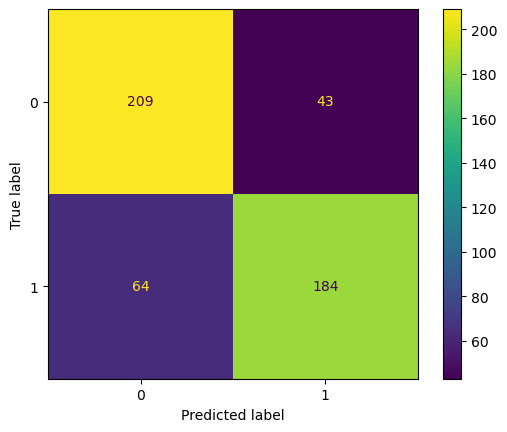

In [20]:
from sklearn.naive_bayes import MultinomialNB

# 1. Train and Evaluate MultinomialNB with CountVectorizer representations
X_train = train_bow_cv
y_train = train_labels_splt
X_val = val_bow_cv
y_val = val_labels

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)

print("MultinomialNB with CountVectorizer representations:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

Your Naive Bayes classifier with your own representations:
              precision    recall  f1-score   support

           0       0.77      0.85      0.80       252
           1       0.82      0.74      0.78       248

    accuracy                           0.79       500
   macro avg       0.80      0.79      0.79       500
weighted avg       0.80      0.79      0.79       500



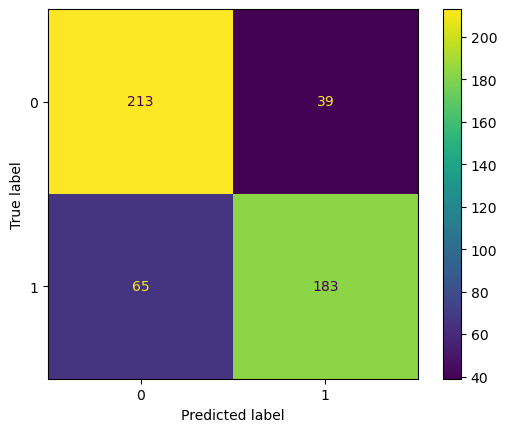

In [21]:
# 2. Train and Evaluate your Naive Bayes classifier with your own representations
X_train = train_bow
y_train = train_labels_splt
X_val = val_bow
y_val = val_labels

nb = NB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)

print("Your Naive Bayes classifier with your own representations:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
Let us look at the *features* built by the `vectorizer`. What seems to be the issue ?

<div class='alert alert-block alert-success'>
            Answer:</div>

The issue with the features built by the `vectorizer` is that they seem to include numerical tokens, such as ('00', '000', '00001', '007', '0080', etc.), found in multiple languages ('14ieme', '14th') and with or without diacritics ('14ieme', '16ième'), which might not be very informative or relevant for text classification tasks.

Including such numerical tokens as features can lead to a couple of problems:

- Sparsity: These numerical tokens might not occur frequently in the text data, leading to sparse feature representations. Sparse feature representations can pose challenges for machine learning models, especially for models like Naive Bayes that rely on counting occurrences of features.

- Relevance: Numerical tokens might not carry much semantic meaning or discriminatory power for distinguishing between different classes of text documents. They are more likely to be noise than informative features

In [22]:
print(vectorizer.get_feature_names_out()[:100])

['00' '000' '00001' '007' '0079' '0080' '0083' '01' '05' '06' '07' '08'
 '09' '10' '100' '1000' '1000000' '100m' '101' '102' '103' '105' '10mil'
 '10th' '10yr' '11' '110' '1100' '11001001' '112' '12' '120' '125' '12s'
 '12th' '13' '134' '13th' '14' '145' '147' '14ieme' '14th' '15' '150' '16'
 '1692' '16th' '16ème' '17' '1700' '1794' '1798' '17th' '18' '180' '1800'
 '1814' '1840' '1840s' '1864' '1880' '1892' '1895' '1897' '18th' '19'
 '1907' '1910' '1912' '1914' '1916' '1918' '1920' '1920s' '1921' '1922'
 '1924' '1925' '1927' '1928' '1929' '1930' '1930s' '1931' '1932' '1933'
 '1934' '1935' '1936' '1937' '1938' '1939' '1940' '1940s' '1941' '1942'
 '1943' '1944' '1945']


### Improving representations

Mainly, the arguments of the class ```vectorizer``` will allow us to easily change the way our textual data is represented. Let us try to work on our *Bag-of-words* representations:
   
#### Do not take into account words that are too frequent:

You can use the argument ```max_df=1.0``` to change the amount of words taken into account. 

#### Try different granularities:

Rather than just counting words, we can count sequences of words - limited in size, of course. 
We call a sequence of $n$ words a $n$-gram: let's try using 2 and 3-grams (bi- and trigrams).
We can also try to use character sequences instead of word sequences.

We will be interested in the options ```analyze='word'``` and ```ngram_range=(1, 2)``` which we'll change to alter the granularity: **obtain classification results with them**.

Again: using these ways of getting more features from our text will probably have more impact if we do not have much training data to begin with ! To accelerate experiments, use the ```Pipeline``` tool from scikit-learn. 

<div class='alert alert-block alert-info'>
            Code:</div>

In [23]:
from sklearn.pipeline import Pipeline

In [24]:
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="word",
                stop_words=None,
                max_df=1.0,
                ngram_range=(1, 1),
            ),
        ),
        ("clf", MultinomialNB()),
    ]
)

print("Base Pipeline:")
pipeline_base.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_base.predict(val_texts)
print(classification_report(y_val, y_pred))

Base Pipeline:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       252
           1       0.81      0.74      0.77       248

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



In [25]:
pipeline_improved = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="word",
                stop_words=None,
                max_df=0.9,
                ngram_range=(2, 3),
            ),
        ),
        ("clf", MultinomialNB()),
    ]
)

print("Improved Pipeline:")
pipeline_improved.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_improved.predict(val_texts)
print(classification_report(y_val, y_pred))

Improved Pipeline:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       252
           1       0.83      0.83      0.83       248

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



#### Tf-idf:

This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

It can be adapted to our case by considering that the context of the second word is the document. However, TF-IDF is generally better suited to low-density matrices, since it will penalize terms that appear in a large part of the documents. 

Experiment with this new representations using the `TfidfTransformer` applied on top of `CountVectorizer`.

<div class='alert alert-block alert-info'>
            Code:</div>

In [26]:
from sklearn.feature_extraction.text import TfidfTransformer

In [27]:
pipeline_base = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="word",
                stop_words=None,
                max_df=1.0,
                ngram_range=(1, 1),
            ),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

print("Base Pipeline with TF-IDF:")
pipeline_base.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_base.predict(val_texts)
print(classification_report(y_val, y_pred))

Base Pipeline with TF-IDF:
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       252
           1       0.87      0.69      0.77       248

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.79       500
weighted avg       0.81      0.80      0.79       500



In [28]:
pipeline_improved = Pipeline(
    [
        (
            "vect",
            CountVectorizer(
                max_features=30000,
                analyzer="word",
                stop_words=None,
                max_df=0.9,
                ngram_range=(2, 3),
            ),
        ),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB()),
    ]
)

print("Improved Pipeline with TF-IDF:")
pipeline_improved.fit(train_texts_splt, train_labels_splt)
y_pred = pipeline_improved.predict(val_texts)
print(classification_report(y_val, y_pred))

Improved Pipeline with TF-IDF:
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       252
           1       0.83      0.84      0.84       248

    accuracy                           0.84       500
   macro avg       0.84      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



## IV - More pre-processing: getting vocabularies

For more flexibility, we will implement separately a function returning the vocabulary. Here we will have to be able to control its size, either by indicating a **maximum number of words**, or a **minimum number of occurrences** to take the words into account. **We add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary**.
<div class='alert alert-block alert-info'>
            Code:</div>

In [29]:
def vocabulary(corpus, count_threshold=5, voc_threshold=10000):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        # words = clean_and_tokenize(sent)
        words = word_tokenize(sent.lower())
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

    # Filter according to count_threhshold
    filtered_word_counts = {
        word: count for word, count in word_counts.items() if count >= count_threshold
    }

    # Extract the words according to frequency
    sorted_words = sorted(
        filtered_word_counts.items(), key=lambda x: x[1], reverse=True
    )

    # Remove the words above voc-threshold
    filtered_words = (
        sorted_words[:voc_threshold] if voc_threshold != 0 else sorted_words
    )

    # Add UNK
    words = [word[0] for word in filtered_words] + ["UNK"]

    # Create vocabulary from "words"
    vocabulary = {word: index for index, word in enumerate(words)}

    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

In [30]:
# Example for testing:
corpus = [
    "I walked down down the boulevard",
    "I walked down the avenue",
    "I ran down the boulevard",
    "I walk down the city",
    "I walk down the the avenue",
]

voc, counts = vocabulary(corpus, count_threshold=3)
print(voc)
print(counts)

# We expect something like this:
# (In this example, we don't count 'UNK' unknown words, but you can if you want to.)
# How useful it may be depends on the data -> we will use the counts later with word2vec, keep that in mind)
#  {'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
#  {'down': 6, 'the': 6, 'i': 5, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'UNK': 3}
{'down': 6, 'the': 6, 'i': 5, 'UNK': 0}


In [31]:
voc, counts = vocabulary(corpus, count_threshold=0)
print(voc)
print(counts)

# We expect something like this:
#  {'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
#  {'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}

{'down': 0, 'the': 1, 'i': 2, 'walked': 3, 'boulevard': 4, 'avenue': 5, 'walk': 6, 'ran': 7, 'city': 8, 'UNK': 9}
{'down': 6, 'the': 6, 'i': 5, 'walked': 2, 'boulevard': 2, 'avenue': 2, 'walk': 2, 'ran': 1, 'city': 1, 'UNK': 0}


### Quick study of the data

We would like to get an idea of what's in these film reviews. So we'll get the vocabulary (in full) and represent the frequencies of the words, in order (be careful, you'll have to use a logarithmic scale): we should find back Zipf's law. This will give us an idea of the size of the vocabulary we will be able to choose: it's a matter of making a compromise between the necessary resources (size of the objects in memory) and the amount of information we can get from them (rare words can bring a lot of information, but it's difficult to learn good representations of them, because they are rare!).  

<div class='alert alert-block alert-info'>
            Code:</div>

In [32]:
# We would like to display the curve of word frequencies given their rank (index) in the vocabulary
vocab, word_counts = vocabulary(train_texts)

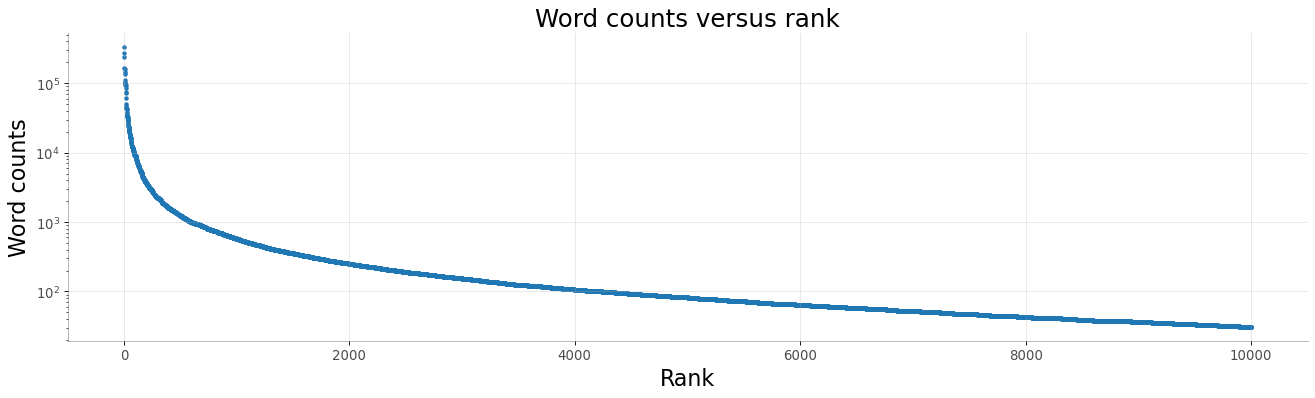

In [33]:
ranks = range(1, len(word_counts) + 1)
counts = list(word_counts.values())


plt.figure(figsize=(20, 5), dpi=80)

plt.scatter(ranks, counts, marker=".")

plt.title("Word counts versus rank", fontsize=22)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Word counts", fontsize=20)

plt.yscale("log")
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.grid(axis="both", alpha=0.3)

plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()

Vocabulary size: 10001
Top 100 words represent 60.82807% of the corpus
Top 1000 words represent 84.51369% of the corpus
Top 10000 words represent 100.00000% of the corpus


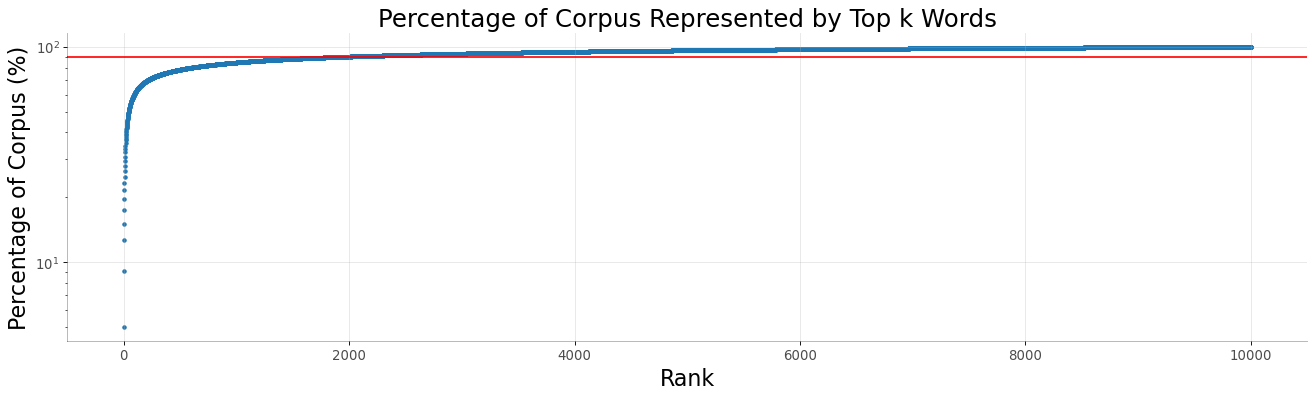

In [34]:
# We would like to know how much of the data is represented by the 'k' most frequent words
total_vocab_size = len(vocab)
print(f"Vocabulary size: {total_vocab_size}")


k_values = [99, 999, 9999]
cumulative_counts = 100 * np.cumsum(counts) / np.sum(counts)
for k in k_values:
    print(f"Top {k+1} words represent {cumulative_counts[k]:.5f}% of the corpus")


plt.figure(figsize=(20, 5), dpi=80)

plt.scatter(ranks, cumulative_counts, marker=".")
plt.axhline(90, linestyle="-", c="r")

plt.title("Percentage of Corpus Represented by Top k Words", fontsize=22)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Percentage of Corpus (%)", fontsize=20)

plt.yscale("log")
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.grid(axis="both", alpha=0.3)

plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
`Word2vec`'s implementation cuts the vocabulary size by using **only words with at least 5 occurrences**, by default. What vocabulary size would it give here ? Does it seem like a good compromise, looking at the graph ? 

<div class='alert alert-block alert-success'>
            Answer:</div>

Given that around $2000$ words seem to explain $90\%$ of the corpus, it suggests that a large portion of the corpus is represented by relatively frequent words. Therefore, removing words with fewer occurrences than around $250$ occurrences would likely be more appropriate than removing only words with $5$ occurrences.

Setting a higher threshold for the minimum number of occurrences, such as $250$ occurrences, would retain the most informative and meaningful words in the vocabulary while still significantly reducing the vocabulary size. This approach ensures that the vocabulary focuses on the most relevant words, which are more likely to capture the essence of the corpus effectively.

It is important to consider, however that rare words may contain important information for the given task (such as sentiment analysis), however they require more memory and may be a less sparse representation of the data, which could be harder to extract generalizable information and draw visualizations from. One should carefully analyze the specific circumstances of the problem and tune its hyperparameters, such as the word count threshold, and compare the training results to the validation results to accomplish a good modelling.

In [35]:
# Count the number of words with at least 5 occurrences
word2vec_vocab_size = sum(1 for count in word_counts.values() if count >= 5)

print("Word2Vec's vocabulary size (with at least 5 occurrences):", word2vec_vocab_size)
print("Total vocabulary size:", total_vocab_size)

Word2Vec's vocabulary size (with at least 5 occurrences): 10000
Total vocabulary size: 10001


In [36]:
sorted(word_counts.items(), key=lambda x: x[1], reverse=False)[:5]

[('UNK', 0), ('ounce', 31), ('outsider', 31), ('come.', 31), ('krishna', 31)]

In [37]:
print(f"Top 2000 words represent {cumulative_counts[2000]:.5f}% of the corpus" )
print(f"2000th word has {list(word_counts.values())[2000]} occurrences")

Top 2000 words represent 90.06130% of the corpus
2000th word has 251 occurrences


### With pre-processing tools from NLTK

We are now going to pre-process our textual data. **Note that this still will only be useful if we do not have a lot of training data to begin with !**

#### Stemming 

Allows to go back to the root of a word: you can group different words around the same root, which facilitates generalization. Use:
```from nltk import SnowballStemmer```

In [38]:
from nltk import SnowballStemmer

stemmer = SnowballStemmer("english")

**Example:**

In [39]:
words = ["singers", "cat", "generalization", "philosophy", "psychology", "philosopher"]
for word in words:
    print("word : %s ; stemmed : %s" % (word, stemmer.stem(word)))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


**Data transformation:**

<div class='alert alert-block alert-info'>
            Code:</div>

In [40]:
def stem(texts):
    """
    Perform stemming on a list of texts.
    Params:
        texts (list of str): List of texts to be stemmed.
    Returns:
        stemmed_texts (list of str): List of stemmed texts.
    """
    stemmer = SnowballStemmer("english")

    stemmed_texts = []
    for text in texts:
        # words = clean_and_tokenize(text)
        words = word_tokenize(text.lower())

        stemmed_text = " ".join([stemmer.stem(word) for word in words])
        stemmed_texts.append(stemmed_text)

    return stemmed_texts

#### Part of speech tags

To generalize, we can also use the Part of Speech (POS) of the words, which will allow us to filter out information that is potentially not useful to the model. We will retrieve the POS of the words using the functions:
```pos_tag```

In [41]:
import nltk
from nltk import pos_tag, word_tokenize

**Example:**

In [42]:
import nltk

# nltk.download("punkt")
# nltk.download("averaged_perceptron_tagger")

pos_tag(word_tokenize(("I am Sam")))

[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

**Data transformation:** only keep nouns, verbs, adverbs, and adjectives (```['NN', 'VB', 'ADJ', 'RB']```) for our model.

<div class='alert alert-block alert-info'>
            Code:</div>

In [43]:
# On version 3.8.1 of NLTK, ADJ does not exist, and rather JJ is used for adjectives
def pos_tag_filter(X, good_tags=["NN", "VB", "JJ", "RB"]):
    """
    Perform part-of-speech tagging and filter out words with specified tags.
    Params:
        X (list of str): List of texts to be processed.
        good_tags (list of str): List of POS tags to keep.
    Returns:
        X_pos (list of str): List of filtered texts.
    """
    X_pos = []

    for text in X:
        # words = clean_and_tokenize(text)
        words = word_tokenize(text.lower())

        tagged_words = pos_tag(words)

        filtered_text = " ".join(
            [word for word, tag in tagged_words if tag in good_tags]
        )

        X_pos.append(filtered_text)

    return X_pos

### Application

<div class='alert alert-block alert-warning'>
            Questions:</div>

Re-draw the Zipf distribution of our data **after reducing their vocabulary with these functions**. How is it affected ? How do you think it could affect results here ?         

<div class='alert alert-block alert-success'>
            Answer:</div>

After reducing the vocabulary with stemming and part-of-speech tagging, the Zipf distribution of the data is affected in several ways:

1. Reduction in Vocabulary Size: The number of unique words in the vocabulary decreases after pre-processing. This reduction in vocabulary size leads to a decrease in the frequency of rare words and a more focused representation of the corpus.

2. Changes in Word Frequencies: The frequencies of words in the corpus changes after pre-processing. Stemming and filtering based on part-of-speech tags results in certain words being merged together (due to stemming) or removed entirely (if they do not belong to the specified part-of-speech tags).

3. Impact on Model Performance: The pre-processing steps could affect the performance of models trained on the pre-processed data. By focusing on specific parts of speech and reducing noise in the data (e.g., removing irrelevant words), the pre-processed data may lead to more effective models with improved generalization capabilities. However, it's also possible that certain linguistic nuances or information contained in the discarded words could be lost, potentially impacting the model's ability to capture certain aspects of the data.

<div class='alert alert-block alert-info'>
            Code:</div>        

In [44]:
# Pre-process the textual data
stemmed_texts = stem(train_texts)
filtered_texts = pos_tag_filter(stemmed_texts)

# Calculate word frequencies
vocab_filtered, word_counts_filtered = vocabulary(filtered_texts)

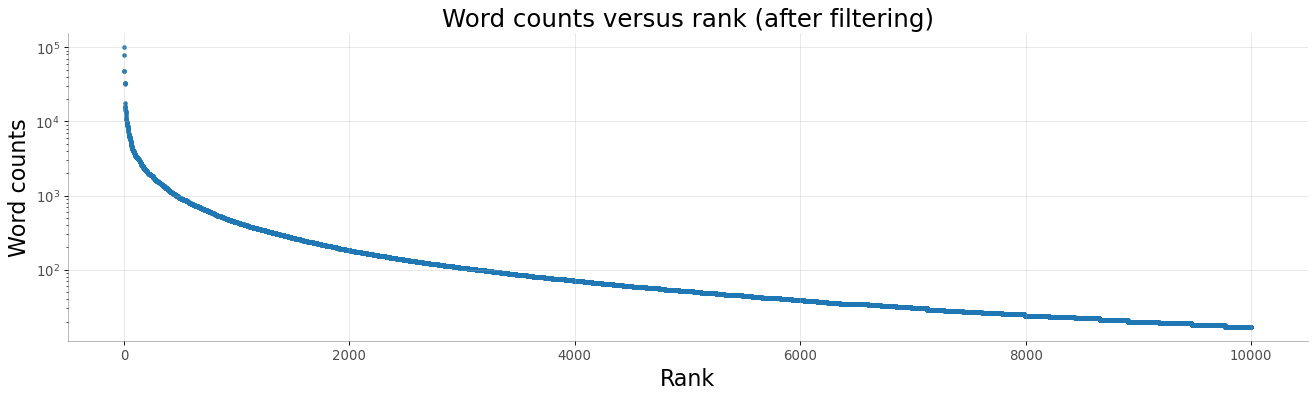

In [45]:
ranks_filtered = range(1, len(word_counts_filtered) + 1)
counts_filtered = list(word_counts_filtered.values())

plt.figure(figsize=(20, 5), dpi=80)

plt.scatter(ranks_filtered, counts_filtered, marker=".")

plt.title("Word counts versus rank (after filtering)", fontsize=22)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Word counts", fontsize=20)

plt.yscale("log")
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.grid(axis="both", alpha=0.3)

plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()

Vocabulary size: 10001
Top 100 words represent 37.49158% of the corpus
Top 1000 words represent 74.15722% of the corpus
Top 10000 words represent 100.00000% of the corpus


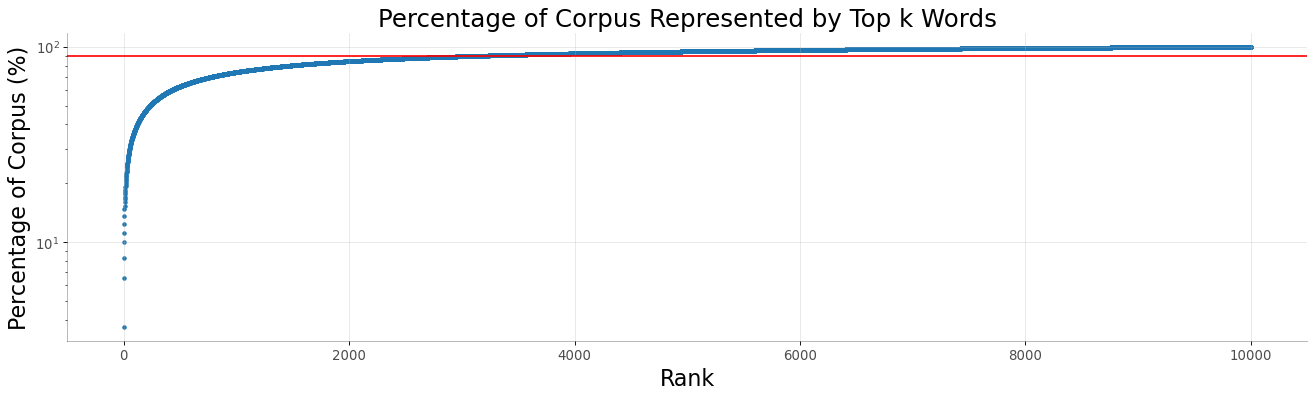

In [46]:
# We would like to know how much of the data is represented by the 'k' most frequent words
total_vocab_size = len(vocab_filtered)
print(f"Vocabulary size: {total_vocab_size}")


k_values = [99, 999, 9999]
cumulative_counts = 100 * np.cumsum(counts_filtered) / np.sum(counts_filtered)
for k in k_values:
    print(f"Top {k+1} words represent {cumulative_counts[k]:.5f}% of the corpus")


plt.figure(figsize=(20, 5), dpi=80)

plt.scatter(ranks, cumulative_counts, marker=".")
plt.axhline(90, linestyle="-", c="r")

plt.title("Percentage of Corpus Represented by Top k Words", fontsize=22)
plt.xlabel("Rank", fontsize=20)
plt.ylabel("Percentage of Corpus (%)", fontsize=20)

plt.yscale("log")
plt.xticks(fontsize=12, alpha=0.7)
plt.yticks(fontsize=12, alpha=0.7)
plt.grid(axis="both", alpha=0.3)

plt.gca().spines[["top", "right"]].set_alpha(0.0)
plt.gca().spines[["bottom", "left"]].set_alpha(0.3)

plt.show()